Instalacija dependency

In [ ]:
!pip install keras_vggface

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/dataset.zip', 'r') 
zip_ref.extractall('/dataset') 
zip_ref.close()

Imports

In [4]:
from __future__ import division
import numpy as np
import keras.backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, ELU, Reshape, Concatenate, Activation
from keras.regularizers import l2
import sklearn
import csv
from PIL import Image
import warnings
from copy import deepcopy
import os
from tqdm import tqdm
from collections import defaultdict
import tensorflow as tf
import cv2
import inspect

Konverzija podataka iz corners formata u minmax i obrnuto

In [5]:
def convert_coordinates(tensor, start_index, conversion, border_pixels='half'):

  tensor1 = np.copy(tensor).astype(np.float)

  if border_pixels == 'half':
        d = 0
  elif border_pixels == 'include':
        d = 1
  elif border_pixels == 'exclude':
        d = -1

  if conversion == 'centroids2corners':
    tensor1[..., start_index] = tensor[..., start_index] - tensor[..., start_index+2] / 2.0 
    tensor1[..., start_index+1] = tensor[..., start_index+1] - tensor[..., start_index+3] / 2.0 
    tensor1[..., start_index+2] = tensor[..., start_index] + tensor[..., start_index+2] / 2.0 
    tensor1[..., start_index+3] = tensor[..., start_index+1] + tensor[..., start_index+3] / 2.0 
  elif conversion == 'corners2centroids':
        tensor1[..., start_index] = (tensor[..., start_index] + tensor[..., start_index+2]) / 2.0 
        tensor1[..., start_index+1] = (tensor[..., start_index+1] + tensor[..., start_index+3]) / 2.0 
        tensor1[..., start_index+2] = tensor[..., start_index+2] - tensor[..., start_index] + d 
        tensor1[..., start_index+3] = tensor[..., start_index+3] - tensor[..., start_index+1] + d 
  elif (conversion == 'minmax2corners') or (conversion == 'corners2minmax'):
    tensor1[..., start_index+1] = tensor[..., start_index+2]
    tensor1[..., start_index+2] = tensor[..., start_index+1]

  return tensor1


Encoder za ulazne podatke

In [6]:
def match_bipartite_greedy(weight_matrix):
  weight_matrix = np.copy(weight_matrix)
  num_ground_truth_boxes = weight_matrix.shape[0]
  all_gt_indices = list(range(num_ground_truth_boxes))

  matches = np.zeros(num_ground_truth_boxes, dtype=np.int)

  for _ in range(num_ground_truth_boxes):

    anchor_indices = np.argmax(weight_matrix, axis=1)
    overlaps = weight_matrix[all_gt_indices, anchor_indices]
    ground_truth_index = np.argmax(overlaps)
    anchor_index = anchor_indices[ground_truth_index]
    matches[ground_truth_index] = anchor_index 

    weight_matrix[ground_truth_index] = 0
    weight_matrix[:,anchor_index] = 0

  return matches

def match_multi(weight_matrix, threshold):
  num_anchor_boxes = weight_matrix.shape[1]
  all_anchor_indices = list(range(num_anchor_boxes)) 

  ground_truth_indices = np.argmax(weight_matrix, axis=0) 
  overlaps = weight_matrix[ground_truth_indices, all_anchor_indices] 

  anchor_indices_thresh_met = np.nonzero(overlaps >= threshold)[0]
  gt_indices_thresh_met = ground_truth_indices[anchor_indices_thresh_met]

  return gt_indices_thresh_met, anchor_indices_thresh_met

def intersection_area_(boxes1, boxes2,mode='outer_product'):

  m = boxes1.shape[0]
  n = boxes2.shape[0]

  xmin = 0
  ymin = 1
  xmax = 2
  ymax = 3

  if mode == 'outer_product':
    min_xy = np.maximum(np.tile(np.expand_dims(boxes1[:,[xmin,ymin]], axis=1), reps=(1, n, 1)),
                            np.tile(np.expand_dims(boxes2[:,[xmin,ymin]], axis=0), reps=(m, 1, 1)))
    max_xy = np.minimum(np.tile(np.expand_dims(boxes1[:,[xmax,ymax]], axis=1), reps=(1, n, 1)),
                            np.tile(np.expand_dims(boxes2[:,[xmax,ymax]], axis=0), reps=(m, 1, 1)))
    side_lengths = np.maximum(0, max_xy - min_xy)

    return side_lengths[:,:,0] * side_lengths[:,:,1]

  elif mode == 'element-wise':
    min_xy = np.maximum(boxes1[:,[xmin,ymin]], boxes2[:,[xmin,ymin]])
    max_xy = np.minimum(boxes1[:,[xmax,ymax]], boxes2[:,[xmax,ymax]])

    side_lengths = np.maximum(0, max_xy - min_xy)

    return side_lengths[:,0] * side_lengths[:,1]

def iou(boxes1, boxes2,mode='outer_product',coords='centroids'):

  if boxes1.ndim == 1: boxes1 = np.expand_dims(boxes1, axis=0)
  if boxes2.ndim == 1: boxes2 = np.expand_dims(boxes2, axis=0)

  if(coords=='centroids'):
    boxes1 = convert_coordinates(boxes1, start_index=0, conversion='centroids2corners')
    boxes2 = convert_coordinates(boxes2, start_index=0, conversion='centroids2corners')
    coords='corners'

  intersection_areas = intersection_area_(boxes1, boxes2,mode=mode)

  m = boxes1.shape[0]
  n = boxes2.shape[0]

  xmin = 0
  ymin = 1
  xmax = 2
  ymax = 3

  if mode == 'outer_product':
    boxes1_areas = np.tile(np.expand_dims((boxes1[:,xmax] - boxes1[:,xmin] ) * (boxes1[:,ymax] - boxes1[:,ymin] ), axis=1), reps=(1,n))
    boxes2_areas = np.tile(np.expand_dims((boxes2[:,xmax] - boxes2[:,xmin] ) * (boxes2[:,ymax] - boxes2[:,ymin] ), axis=0), reps=(m,1))

  elif mode == 'element-wise':
    boxes1_areas = (boxes1[:,xmax] - boxes1[:,xmin]) * (boxes1[:,ymax] - boxes1[:,ymin])
    boxes2_areas = (boxes2[:,xmax] - boxes2[:,xmin]) * (boxes2[:,ymax] - boxes2[:,ymin])

  union_areas = boxes1_areas + boxes2_areas - intersection_areas

  return intersection_areas / union_areas

class SSDInputEncoder:

  def __init__(self,
                 img_height,
                 img_width,
                 n_classes,
                 predictor_sizes,
                 scales= [0.08, 0.16, 0.32, 0.64, 0.96] ,
                 aspect_ratios_global=[0.5, 1.0, 2.0],
                 two_boxes_for_ar1=True,
                 variances=[0.1, 0.1, 0.2, 0.2],
                 matching_type='multi',
                 pos_iou_threshold=0.5,
                 neg_iou_limit=0.3,
                 background_id=0):
    
    predictor_sizes = np.array(predictor_sizes)
    if predictor_sizes.ndim == 1:
      predictor_sizes = np.expand_dims(predictor_sizes, axis=0)

    self.img_height = img_height
    self.img_width = img_width
    self.n_classes = n_classes + 1
    self.predictor_sizes = predictor_sizes
    self.scales = scales
    self.aspect_ratios = [aspect_ratios_global] * predictor_sizes.shape[0]
    self.variances = variances
    self.matching_type = matching_type
    self.pos_iou_threshold = pos_iou_threshold
    self.neg_iou_limit = neg_iou_limit
    self.background_id = background_id
    self.two_boxes_for_ar1=two_boxes_for_ar1

    self.n_boxes = len(aspect_ratios_global) + 1

    self.boxes_list = []

    self.wh_list_diag = []
    self.steps_diag = []
    self.offsets_diag = []
    self.centers_diag = []

    for i in range(len(self.predictor_sizes)):
      boxes, center, wh, step, offset = self.generate_anchor_boxes_for_layer(feature_map_size=self.predictor_sizes[i],aspect_ratios=self.aspect_ratios[i],
                                                                              this_scale=self.scales[i],next_scale=self.scales[i+1],diagnostics=True)
      self.boxes_list.append(boxes)
      self.wh_list_diag.append(wh)
      self.steps_diag.append(step)
      self.offsets_diag.append(offset)
      self.centers_diag.append(center)

  def __call__(self, ground_truth_labels, diagnostics=False):

    class_id = 0
    xmin = 1
    ymin = 2
    xmax = 3
    ymax = 4

    batch_size = len(ground_truth_labels)

    y_encoded = self.generate_encoding_template(batch_size=batch_size, diagnostics=False)

    y_encoded[:, :, self.background_id] = 1 
    n_boxes = y_encoded.shape[1]
    class_vectors = np.eye(self.n_classes)

    for i in range(batch_size):
      if ground_truth_labels[i].size == 0: continue
      labels = ground_truth_labels[i].astype(np.float)

      labels = convert_coordinates(labels, start_index=xmin, conversion='corners2centroids', border_pixels='half')

      classes_one_hot = class_vectors[labels[:, class_id].astype(np.int)] 
      labels_one_hot = np.concatenate([classes_one_hot, labels[:, [xmin,ymin,xmax,ymax]]], axis=-1)

      similarities = iou(labels[:,[xmin,ymin,xmax,ymax]], y_encoded[i,:,-12:-8])

      bipartite_matches = match_bipartite_greedy(weight_matrix=similarities)

      y_encoded[i, bipartite_matches, :-8] = labels_one_hot

      similarities[:, bipartite_matches] = 0

      if self.matching_type == 'multi':
        matches = match_multi(weight_matrix=similarities, threshold=self.pos_iou_threshold)
        y_encoded[i, matches[1], :-8] = labels_one_hot[matches[0]]
        similarities[:, matches[1]] = 0

      max_background_similarities = np.amax(similarities, axis=0)
      neutral_boxes = np.nonzero(max_background_similarities >= self.neg_iou_limit)[0]
      y_encoded[i, neutral_boxes, self.background_id] = 0


    y_encoded[:,:,[-12,-11]] -= y_encoded[:,:,[-8,-7]]
    y_encoded[:,:,[-12,-11]] /= y_encoded[:,:,[-6,-5]] * y_encoded[:,:,[-4,-3]] 
    y_encoded[:,:,[-10,-9]] /= y_encoded[:,:,[-6,-5]]
    y_encoded[:,:,[-10,-9]] = np.log(y_encoded[:,:,[-10,-9]]) / y_encoded[:,:,[-2,-1]]

    return y_encoded

  def generate_anchor_boxes_for_layer(self,feature_map_size,aspect_ratios,this_scale,next_scale,diagnostics=False):
    size = min(self.img_height, self.img_width)

    wh_list = []
    for ar in aspect_ratios:
      if (ar == 1):
        box_height = box_width = this_scale * size
        wh_list.append((box_width, box_height))
        if self.two_boxes_for_ar1:
          box_height = box_width = np.sqrt(this_scale * next_scale) * size
          wh_list.append((box_width, box_height))
      else:
        box_width = this_scale * size * np.sqrt(ar)
        box_height = this_scale * size / np.sqrt(ar)
        wh_list.append((box_width, box_height))
    wh_list = np.array(wh_list)
    n_boxes = len(wh_list)

    step_height = self.img_height / feature_map_size[0]
    step_width = self.img_width / feature_map_size[1]

    offset_height = 0.5
    offset_width = 0.5

    cy = np.linspace(offset_height * step_height, (offset_height + feature_map_size[0] - 1) * step_height, feature_map_size[0])
    cx = np.linspace(offset_width * step_width, (offset_width + feature_map_size[1] - 1) * step_width, feature_map_size[1])
    cx_grid, cy_grid = np.meshgrid(cx, cy)
    cx_grid = np.expand_dims(cx_grid, -1) 
    cy_grid = np.expand_dims(cy_grid, -1)

    boxes_tensor = np.zeros((feature_map_size[0], feature_map_size[1], n_boxes, 4))

    boxes_tensor[:, :, :, 0] = np.tile(cx_grid, (1, 1, n_boxes)) # Set cx
    boxes_tensor[:, :, :, 1] = np.tile(cy_grid, (1, 1, n_boxes)) # Set cy
    boxes_tensor[:, :, :, 2] = wh_list[:, 0] # Set w
    boxes_tensor[:, :, :, 3] = wh_list[:, 1] # Set h

    if diagnostics:
        return boxes_tensor, (cy, cx), wh_list, (step_height, step_width), (offset_height, offset_width)
    else:
        return boxes_tensor

  def generate_encoding_template(self, batch_size, diagnostics=False):

    boxes_batch = []
    for boxes in self.boxes_list:
      boxes = np.expand_dims(boxes, axis=0)
      boxes = np.tile(boxes, (batch_size, 1, 1, 1, 1))
      boxes = np.reshape(boxes, (batch_size, -1, 4))
      boxes_batch.append(boxes)

    boxes_tensor = np.concatenate(boxes_batch, axis=1)

    classes_tensor = np.zeros((batch_size, boxes_tensor.shape[1], self.n_classes))

    variances_tensor = np.zeros_like(boxes_tensor)
    variances_tensor += self.variances # Long live broadcasting

    y_encoding_template = np.concatenate((classes_tensor, boxes_tensor, boxes_tensor, variances_tensor), axis=2)

    if diagnostics:
        return y_encoding_template, self.centers_diag, self.wh_list_diag, self.steps_diag, self.offsets_diag
    else:
        return y_encoding_template

Filter za boxove - vraca validne

In [7]:
class BoxFilter:

  def __init__(self,
                 check_overlap=True,
                 check_min_area=True,
                 check_degenerate=True,
                 overlap_criterion='center_point',
                 overlap_bounds=(0.3, 1.0),
                 min_area=16,
                 labels_format={'class_id': 0, 'xmin': 1, 'ymin': 2, 'xmax': 3, 'ymax': 4}):
    self.overlap_criterion = overlap_criterion
    self.overlap_bounds = overlap_bounds
    self.min_area = min_area
    self.check_overlap = check_overlap
    self.check_min_area = check_min_area
    self.check_degenerate = check_degenerate
    self.labels_format = labels_format

  def __call__(self,
                 labels,
                 image_height=None,
                 image_width=None):
    labels = np.copy(labels)

    xmin = self.labels_format['xmin']
    ymin = self.labels_format['ymin']
    xmax = self.labels_format['xmax']
    ymax = self.labels_format['ymax']

    requirements_met = np.ones(shape=labels.shape[0], dtype=np.bool)

    if self.check_degenerate:
        non_degenerate = (labels[:,xmax] > labels[:,xmin]) * (labels[:,ymax] > labels[:,ymin])
        requirements_met *= non_degenerate
    
    return labels[requirements_met]
     

AnchorBoxes sloj - kreira izlazni tenzor koji sadrzi koordinate anchor boxova

In [8]:
class AnchorBoxes(Layer):
  def __init__(self,
                 img_height,
                 img_width,
                 this_scale,
                 next_scale,
                 aspect_ratios=[0.5, 1.0, 2.0],
                 variances=[0.1, 0.1, 0.2, 0.2],
                 coords='centroids',
                 **kwargs):
        self.img_height = img_height
        self.img_width = img_width
        self.this_scale = this_scale
        self.next_scale = next_scale
        self.aspect_ratios = aspect_ratios
        self.variances = variances
        self.coords = coords

        self.n_boxes = len(aspect_ratios) + 1
        super(AnchorBoxes, self).__init__(**kwargs)

  def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(AnchorBoxes, self).build(input_shape)
  
  def call(self, x, mask=None):

    size = min(self.img_height, self.img_width) #koristi se kraca ivica slike da bi se izracunalo w i h pomocu scale i aspect_ratios

    wh_list = []
    for ar in self.aspect_ratios:
        if (ar == 1):
            # Racuna se obicna anchor box za aspect ratio 1.
            box_height = box_width = self.this_scale * size
            wh_list.append((box_width, box_height))

            #malo veca anchor box koju izracunamo koriteci geometrijsku sredinu ove i naredne vrednosti za skaliranje
            box_height = box_width = np.sqrt(self.this_scale * self.next_scale) * size
            wh_list.append((box_width, box_height))
        else:
            box_height = self.this_scale * size / np.sqrt(ar)
            box_width = self.this_scale * size * np.sqrt(ar)
            wh_list.append((box_width, box_height))
    wh_list = np.array(wh_list)
    

    #treba nam oblik input tenzora
    batch_size, feature_map_height, feature_map_width, feature_map_channels = x.shape

    #sada se racuna grid centralnih tecki boxova - isti za sve aspect ratiove

    #racunamo koliki je step tj koliko su horizontalno i vertikalno udaljene centralne tacke boxa
    step_height = self.img_height / feature_map_height
    step_width = self.img_width / feature_map_width

    #racunamo ofsete tj na koliko piksela je centralna tacka prvog anchor boxa od gornjeg levog ugla slike
    offset_height = 0.5
    offset_width = 0.5

    #racunamo grid
    cy = np.linspace(offset_height * step_height, (offset_height + feature_map_height - 1) * step_height, feature_map_height)
    cx = np.linspace(offset_width * step_width, (offset_width + feature_map_width - 1) * step_width, feature_map_width)
    cx_grid, cy_grid = np.meshgrid(cx, cy)
    cx_grid = np.expand_dims(cx_grid, -1) # treba nam zbog np.tile()
    cy_grid = np.expand_dims(cy_grid, -1) 

    # pravimo 4-dimenzionalni tenzor `(feature_map_height, feature_map_width, n_boxes, 4)`
    # a poslednja dimenzija mu je `(cx, cy, w, h)`
    boxes_tensor = np.zeros((feature_map_height, feature_map_width, self.n_boxes, 4))

    boxes_tensor[:, :, :, 0] = np.tile(cx_grid, (1, 1, self.n_boxes)) # Set cx
    boxes_tensor[:, :, :, 1] = np.tile(cy_grid, (1, 1, self.n_boxes)) # Set cy
    boxes_tensor[:, :, :, 2] = wh_list[:, 0] # Set w
    boxes_tensor[:, :, :, 3] = wh_list[:, 1] # Set h

    # konvertujemo `(cx, cy, w, h)` u `(xmin, xmax, ymin, ymax)`
    boxes_tensor = convert_coordinates(boxes_tensor, start_index=0, conversion='centroids2corners')

    #odseca se box tako da bude unutar slike
    x_coords = boxes_tensor[:,:,:,[0, 2]]
    x_coords[x_coords >= self.img_width] = self.img_width - 1
    x_coords[x_coords < 0] = 0
    boxes_tensor[:,:,:,[0, 2]] = x_coords
    y_coords = boxes_tensor[:,:,:,[1, 3]]
    y_coords[y_coords >= self.img_height] = self.img_height - 1
    y_coords[y_coords < 0] = 0
    boxes_tensor[:,:,:,[1, 3]] = y_coords

    # konvertujemo `(xmin, ymin, xmax, ymax)` to `(cx, cy, w, h)`.
    boxes_tensor = convert_coordinates(boxes_tensor, start_index=0, conversion='corners2centroids', border_pixels='half')

    # dodaju se variances na boxes?tensor pa ce on imati oblik (feature_map_height, feature_map_width, n_boxes, 8)
    variances_tensor = np.zeros_like(boxes_tensor) 
    variances_tensor += self.variances 
    boxes_tensor = np.concatenate((boxes_tensor, variances_tensor), axis=-1)

    # dodajemo i batch_size pa dobijamo oblik `(batch_size, feature_map_height, feature_map_width, n_boxes, 8)`
    boxes_tensor = np.expand_dims(boxes_tensor, axis=0)
    boxes_tensor = K.tile(K.constant(boxes_tensor, dtype='float32'), (K.shape(x)[0], 1, 1, 1, 1))

    return boxes_tensor

  def compute_output_shape(self, input_shape):
        batch_size, feature_map_height, feature_map_width, feature_map_channels = input_shape
        return (batch_size, feature_map_height, feature_map_width, self.n_boxes, 8)

  def get_config(self):
        config = {
            'img_height': self.img_height,
            'img_width': self.img_width,
            'this_scale': self.this_scale,
            'next_scale': self.next_scale,
            'aspect_ratios': list(self.aspect_ratios),
            'variances': list(self.variances),
            'coords': self.coords,
        }
        base_config = super(AnchorBoxes, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



        
  
    

Model

In [9]:
def build_model(image_size,n_classes,l2_reg,aspect_ratios_input = [0.5, 1.0, 2.0],scales = [0.08, 0.16, 0.32, 0.64, 0.96]):

  n_predictor_layers = 4
  n_classes += 1
  img_height, img_width, img_channels = image_size[0], image_size[1], image_size[2]

  aspect_ratios =[aspect_ratios_input] * n_predictor_layers

  n_boxes = [len(aspect_ratios_input) + 1] * n_predictor_layers

  #base network

  x = Input(shape=(img_height, img_width, img_channels)) #ulaz

  conv1 = Conv2D(32, (5, 5), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1')(x)
  conv1 = BatchNormalization(axis=3, momentum=0.99, name='bn1')(conv1) # normalizacija izlaza
  conv1 = ELU(name='elu1')(conv1) # aktivaciona funkcija
  pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)

  conv2 = Conv2D(48, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2')(pool1)
  conv2 = BatchNormalization(axis=3, momentum=0.99, name='bn2')(conv2)
  conv2 = ELU(name='elu2')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)

  conv3 = Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3')(pool2)
  conv3 = BatchNormalization(axis=3, momentum=0.99, name='bn3')(conv3)
  conv3 = ELU(name='elu3')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)

  conv4 = Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4')(pool3)
  conv4 = BatchNormalization(axis=3, momentum=0.99, name='bn4')(conv4)
  conv4 = ELU(name='elu4')(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4')(conv4)

  conv5 = Conv2D(48, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5')(pool4)
  conv5 = BatchNormalization(axis=3, momentum=0.99, name='bn5')(conv5)
  conv5 = ELU(name='elu5')(conv5)
  pool5 = MaxPooling2D(pool_size=(2, 2), name='pool5')(conv5)

  conv6 = Conv2D(48, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6')(pool5)
  conv6 = BatchNormalization(axis=3, momentum=0.99, name='bn6')(conv6)
  conv6 = ELU(name='elu6')(conv6)
  pool6 = MaxPooling2D(pool_size=(2, 2), name='pool6')(conv6)

  conv7 = Conv2D(32, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7')(pool6)
  conv7 = BatchNormalization(axis=3, momentum=0.99, name='bn7')(conv7)
  conv7 = ELU(name='elu7')(conv7)

  #predictor layers

  classes4 = Conv2D(n_boxes[0] * n_classes, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='classes4')(conv4)
  classes5 = Conv2D(n_boxes[1] * n_classes, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='classes5')(conv5)
  classes6 = Conv2D(n_boxes[2] * n_classes, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='classes6')(conv6)
  classes7 = Conv2D(n_boxes[3] * n_classes, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='classes7')(conv7)

  boxes4 = Conv2D(n_boxes[0] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='boxes4')(conv4)
  boxes5 = Conv2D(n_boxes[1] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='boxes5')(conv5)
  boxes6 = Conv2D(n_boxes[2] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='boxes6')(conv6)
  boxes7 = Conv2D(n_boxes[3] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='boxes7')(conv7)

  anchors4 = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1], aspect_ratios=aspect_ratios[0],name='anchors4')(boxes4)
  anchors5 = AnchorBoxes(img_height, img_width, this_scale=scales[1], next_scale=scales[2], aspect_ratios=aspect_ratios[1],name='anchors5')(boxes5)
  anchors6 = AnchorBoxes(img_height, img_width, this_scale=scales[2], next_scale=scales[3], aspect_ratios=aspect_ratios[2],name='anchors6')(boxes6)
  anchors7 = AnchorBoxes(img_height, img_width, this_scale=scales[3], next_scale=scales[4], aspect_ratios=aspect_ratios[3],name='anchors7')(boxes7)

  #izmena izlaza iz predictor layera

  classes4_reshaped = Reshape((-1, n_classes), name='classes4_reshape')(classes4)
  classes5_reshaped = Reshape((-1, n_classes), name='classes5_reshape')(classes5)
  classes6_reshaped = Reshape((-1, n_classes), name='classes6_reshape')(classes6)
  classes7_reshaped = Reshape((-1, n_classes), name='classes7_reshape')(classes7)

  boxes4_reshaped = Reshape((-1, 4), name='boxes4_reshape')(boxes4)
  boxes5_reshaped = Reshape((-1, 4), name='boxes5_reshape')(boxes5)
  boxes6_reshaped = Reshape((-1, 4), name='boxes6_reshape')(boxes6)
  boxes7_reshaped = Reshape((-1, 4), name='boxes7_reshape')(boxes7)

  anchors4_reshaped = Reshape((-1, 8), name='anchors4_reshape')(anchors4)
  anchors5_reshaped = Reshape((-1, 8), name='anchors5_reshape')(anchors5)
  anchors6_reshaped = Reshape((-1, 8), name='anchors6_reshape')(anchors6)
  anchors7_reshaped = Reshape((-1, 8), name='anchors7_reshape')(anchors7)

  #konkatenacija izlaza iz predictor layera i anchor-a

  classes_concat = Concatenate(axis=1, name='classes_concat')([classes4_reshaped,classes5_reshaped,classes6_reshaped,classes7_reshaped])

  boxes_concat = Concatenate(axis=1, name='boxes_concat')([boxes4_reshaped,boxes5_reshaped,boxes6_reshaped,boxes7_reshaped])

  anchors_concat = Concatenate(axis=1, name='anchors_concat')([anchors4_reshaped,anchors5_reshaped,anchors6_reshaped,anchors7_reshaped])

  #softmax za predikciju klasa
  classes_softmax = Activation('softmax', name='classes_softmax')(classes_concat)

  predictions = Concatenate(axis=2, name='predictions')([classes_softmax, boxes_concat, anchors_concat])

  model = Model(inputs=x, outputs=predictions)

  return model

Loss funkcija za SSD, preuzeta iz radova sa : https://arxiv.org/abs/1512.02325

In [10]:
class SSDLoss:
  def __init__(self,neg_pos_ratio=3,n_neg_min=0,alpha=1.0):
    self.neg_pos_ratio = neg_pos_ratio
    self.n_neg_min = n_neg_min
    self.alpha = alpha

  def smooth_L1_loss(self, y_true, y_pred):
    absolute_loss = tf.abs(y_true - y_pred)
    square_loss = 0.5 * (y_true - y_pred)**2
    l1_loss = tf.where(tf.less(absolute_loss, 1.0), square_loss, absolute_loss - 0.5)
    return tf.reduce_sum(l1_loss, axis=-1)

  def log_loss(self, y_true, y_pred):
    y_pred = tf.maximum(y_pred, 1e-15)
    log_loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    return log_loss

  def compute_loss(self, y_true, y_pred):
    self.neg_pos_ratio = self.neg_pos_ratio
    self.n_neg_min = self.n_neg_min
    self.alpha = self.alpha

    batch_size = tf.shape(y_pred)[0] 
    n_boxes = tf.shape(y_pred)[1]

    classification_loss = tf.cast(self.log_loss(y_true[:,:,:-12], y_pred[:,:,:-12]), dtype=tf.float32)
    localization_loss = tf.cast(self.smooth_L1_loss(y_true[:,:,-12:-8], y_pred[:,:,-12:-8]), dtype=tf.float32)

    negatives = y_true[:,:,0]
    positives = tf.cast(tf.reduce_max(y_true[:,:,1:-12], axis=-1), dtype=tf.float32)

    n_positive = tf.reduce_sum(positives)

    pos_class_loss = tf.reduce_sum(classification_loss * positives, axis=-1)

    neg_class_loss_all = classification_loss * negatives
    n_neg_losses = tf.math.count_nonzero(neg_class_loss_all, dtype=tf.int32)

    n_negative_keep = tf.minimum(tf.maximum(self.neg_pos_ratio * tf.cast(n_positive, tf.int32), self.n_neg_min), n_neg_losses)

    def f1():
      return tf.zeros([batch_size])

    def f2():
      neg_class_loss_all_1D = tf.reshape(neg_class_loss_all, [-1])

      values, indices = tf.nn.top_k(neg_class_loss_all_1D,k=n_negative_keep,sorted=False)

      negatives_keep = tf.scatter_nd(indices=tf.expand_dims(indices, axis=1),updates=tf.ones_like(indices, dtype=tf.int32),shape=tf.shape(neg_class_loss_all_1D))

      negatives_keep = tf.cast(tf.reshape(negatives_keep, [batch_size, n_boxes]), dtype=tf.float32)

      neg_class_loss = tf.reduce_sum(classification_loss * negatives_keep, axis=-1)
      return neg_class_loss

    neg_class_loss = tf.cond(tf.equal(n_neg_losses, tf.constant(0)), f1, f2)

    class_loss = pos_class_loss + neg_class_loss

    loc_loss = tf.reduce_sum(localization_loss * positives, axis=-1)

    total_loss = (class_loss + self.alpha * loc_loss) / tf.maximum(1.0, n_positive)

    total_loss = total_loss * tf.cast(batch_size, dtype=tf.float32)

    return total_loss

Transformacije

In [11]:
class ConvertColor:

    def __init__(self, current='RGB', to='HSV', keep_3ch=True):

        self.current = current
        self.to = to
        self.keep_3ch = keep_3ch

    def __call__(self, image, labels=None):
        if self.current == 'RGB' and self.to == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif self.current == 'RGB' and self.to == 'GRAY':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            if self.keep_3ch:
                image = np.stack([image] * 3, axis=-1)
        elif self.current == 'HSV' and self.to == 'RGB':
            image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
        elif self.current == 'HSV' and self.to == 'GRAY':
            image = cv2.cvtColor(image, cv2.COLOR_HSV2GRAY)
            if self.keep_3ch:
                image = np.stack([image] * 3, axis=-1)
        if labels is None:
            return image
        else:
            return image, labels

class ConvertDataType:

    def __init__(self, to='uint8'):
        self.to = to

    def __call__(self, image, labels=None):
        if self.to == 'uint8':
            image = np.round(image, decimals=0).astype(np.uint8)
        else:
            image = image.astype(np.float32)
        if labels is None:
            return image
        else:
            return image, labels

class ConvertTo3Channels:
    def __init__(self):
        pass

    def __call__(self, image, labels=None):
        if image.ndim == 2:
            image = np.stack([image] * 3, axis=-1)
        elif image.ndim == 3:
            if image.shape[2] == 1:
                image = np.concatenate([image] * 3, axis=-1)
            elif image.shape[2] == 4:
                image = image[:,:,:3]
        if labels is None:
            return image
        else:
            return image, labels

class Hue:
  def __init__(self, delta):
      self.delta = delta

  def __call__(self, image, labels=None):
      image[:, :, 0] = (image[:, :, 0] + self.delta) % 180.0
      if labels is None:
          return image
      else:
          return image, labels

class RandomHue:
    def __init__(self, max_delta=18, prob=0.5):
        self.max_delta = max_delta
        self.prob = prob
        self.change_hue = Hue(delta=0)

    def __call__(self, image, labels=None):
        p = np.random.uniform(0,1)
        if p >= (1.0-self.prob):
            self.change_hue.delta = np.random.uniform(-self.max_delta, self.max_delta)
            return self.change_hue(image, labels)
        elif labels is None:
            return image
        else:
            return image, labels

class Saturation:
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, image, labels=None):
        image[:,:,1] = np.clip(image[:,:,1] * self.factor, 0, 255)
        if labels is None:
            return image
        else:
            return image, labels

class RandomSaturation:
    def __init__(self, lower=0.3, upper=2.0, prob=0.5):
        self.lower = lower
        self.upper = upper
        self.prob = prob
        self.change_saturation = Saturation(factor=1.0)

    def __call__(self, image, labels=None):
        p = np.random.uniform(0,1)
        if p >= (1.0-self.prob):
            self.change_saturation.factor = np.random.uniform(self.lower, self.upper)
            return self.change_saturation(image, labels)
        elif labels is None:
            return image
        else:
            return image, labels

class Brightness:
    def __init__(self, delta):
        self.delta = delta

    def __call__(self, image, labels=None):
        image = np.clip(image + self.delta, 0, 255)
        if labels is None:
            return image
        else:
            return image, labels

class RandomBrightness:
    def __init__(self, lower=-84, upper=84, prob=0.5):
        self.lower = float(lower)
        self.upper = float(upper)
        self.prob = prob
        self.change_brightness = Brightness(delta=0)

    def __call__(self, image, labels=None):
        p = np.random.uniform(0,1)
        if p >= (1.0-self.prob):
            self.change_brightness.delta = np.random.uniform(self.lower, self.upper)
            return self.change_brightness(image, labels)
        elif labels is None:
            return image
        else:
            return image, labels

class Contrast:
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, image, labels=None):
        image = np.clip(127.5 + self.factor * (image - 127.5), 0, 255)
        if labels is None:
            return image
        else:
            return image, labels

class RandomContrast:
    def __init__(self, lower=0.5, upper=1.5, prob=0.5):
        self.lower = lower
        self.upper = upper
        self.prob = prob
        self.change_contrast = Contrast(factor=1.0)

    def __call__(self, image, labels=None):
        p = np.random.uniform(0,1)
        if p >= (1.0-self.prob):
            self.change_contrast.factor = np.random.uniform(self.lower, self.upper)
            return self.change_contrast(image, labels)
        elif labels is None:
            return image
        else:
            return image, labels


class DataAugmentation:

    def __init__(self,
                 random_brightness=(-48, 48, 0.5),
                 random_contrast=(0.5, 1.8, 0.5),
                 random_saturation=(0.5, 1.8, 0.5),
                 random_hue=(18, 0.5),
                 overlap_criterion='area',
                 bounds_box_filter=(0.3, 1.0),
                 labels_format={'class_id': 0, 'xmin': 1, 'ymin': 2, 'xmax': 3, 'ymax': 4}):

        self.overlap_criterion = overlap_criterion
        self.bounds_box_filter = bounds_box_filter
        self.labels_format = labels_format

        self.box_filter = BoxFilter(check_overlap=True,
                                    check_min_area=True,
                                    check_degenerate=True,
                                    overlap_criterion=self.overlap_criterion,
                                    overlap_bounds=self.bounds_box_filter,
                                    min_area=16,
                                    labels_format=self.labels_format)

        self.convert_RGB_to_HSV = ConvertColor(current='RGB', to='HSV')
        self.convert_HSV_to_RGB = ConvertColor(current='HSV', to='RGB')
        self.convert_to_float32 = ConvertDataType(to='float32')
        self.convert_to_uint8 = ConvertDataType(to='uint8')
        self.convert_to_3_channels = ConvertTo3Channels()

        self.random_brightness = RandomBrightness(lower=random_brightness[0], upper=random_brightness[1], prob=random_brightness[2])
        self.random_contrast = RandomContrast(lower=random_contrast[0], upper=random_contrast[1], prob=random_contrast[2])
        self.random_saturation = RandomSaturation(lower=random_saturation[0], upper=random_saturation[1], prob=random_saturation[2])
        self.random_hue = RandomHue(max_delta=random_hue[0], prob=random_hue[1])

        self.sequence = [self.convert_to_3_channels,
                          self.convert_to_float32,
                          self.random_brightness,
                          self.random_contrast,
                          self.convert_to_uint8,
                          self.convert_RGB_to_HSV,
                          self.convert_to_float32,
                          self.random_saturation,
                          self.random_hue,
                          self.convert_to_uint8,
                          self.convert_HSV_to_RGB]

    def __call__(self, image, labels=None):

        if not (labels is None):
          for transform in self.sequence:
            image, labels = transform(image, labels)
          return image, labels
        else:
          for transform in self.sequence:
            image = transform(image)
          return image
        

Generator podataka

In [12]:
import pickle
class DataGenerator:
  def __init__(self,
                 labels_output_format=('class_id', 'xmin', 'ymin', 'xmax', 'ymax'),
                 filenames=None,
                 filenames_type='text',
                 images_dir=None,
                 labels=None,
                 image_ids=None):
    self.labels_output_format = labels_output_format
    self.labels_format={'class_id': labels_output_format.index('class_id'),
                        'xmin': labels_output_format.index('xmin'),
                        'ymin': labels_output_format.index('ymin'),
                        'xmax': labels_output_format.index('xmax'),
                        'ymax': labels_output_format.index('ymax')}

    if not filenames is None:
        if isinstance(filenames, str):
           self.filenames = [os.path.join(images_dir, line.strip()) for line in f]
        else:
            raise ValueError("`filenames` must be a string representing a filepath (to text file).")
    else:
        self.filenames = []

    if not labels is None:
        if isinstance(labels, str):
            with open(labels, 'rb') as f:
                self.labels = pickle.load(f)
        elif isinstance(labels, (list, tuple)):
            self.labels = labels
        else:
            raise ValueError("`labels` must be either a Python list/tuple or a string representing the path to a pickled file containing a list/tuple. The value you passed is neither of the two.")
    else:
        self.labels = None

    if not image_ids is None:
        if isinstance(image_ids, str):
            with open(image_ids, 'rb') as f:
                self.image_ids = pickle.load(f)
        elif isinstance(image_ids, (list, tuple)):
            self.image_ids = image_ids
        else:
            raise ValueError("`image_ids` must be either a Python list/tuple or a string representing the path to a pickled file containing a list/tuple. The value you passed is neither of the two.")
    else:
        self.image_ids = None

  def parse_csv(self,
                  images_dir,
                  labels_filename,
                  input_format,
                  include_classes=[1, 2, 3, 4],  #1-none, 2 - red, 3-white, 4-blue, 5-yellow
                  random_sample=False,
                  ret=False):
     
      self.images_dir = images_dir
      self.labels_filename = labels_filename
      self.input_format = input_format
      self.include_classes = include_classes

      self.filenames = []
      self.labels = []

      data = []

      with open(self.labels_filename, newline='') as csvfile:
        csvread = csv.reader(csvfile, delimiter=',')
        next(csvread) 
        for row in csvread: 
          box = [] 
          box.append(row[self.input_format.index('image_name')].strip()) 
          for element in self.labels_output_format: 
            if (element == 'class_id'):
              class_name = row[self.input_format.index(element)]
              if class_name == 'none':
                box.append(1)
              elif (class_name == 'red'):
                box.append(2)
              elif (class_name == 'white'):
                box.append(3)
              elif (class_name == 'blue'):
                box.append(4)
              elif (class_name == 'yellow'):
                box.append(5)
              continue
            box.append(int(row[self.input_format.index(element)].strip())) 
          data.append(box)

      data = sorted(data) 


      current_file = data[0][0] # trenutna slika
      current_labels = [] 
      add_to_dataset = False
      for i, box in enumerate(data):

          if box[0] == current_file: # provera da li ova box tj linija iz csv fajla odgovara trenutnoj slici
              current_labels.append(box[1:])
              if i == len(data)-1: # ako je poslednja linija
                  self.labels.append(np.stack(current_labels, axis=0))
                  self.filenames.append(os.path.join(self.images_dir, current_file))
          else: 
              self.labels.append(np.stack(current_labels, axis=0))
              self.filenames.append(os.path.join(self.images_dir, current_file))
              current_labels = [] # reset labela za novi fajl
              current_file = box[0]
              current_labels.append(box[1:])
              if i == len(data)-1: # ako je poslednja linja fajla
                  self.labels.append(np.stack(current_labels, axis=0))
                  self.filenames.append(os.path.join(self.images_dir, current_file))

      if ret: # In case we want to return these
          return self.filenames, self.labels

  def generate(self,
                batch_size=32,
                shuffle=True,
                transformations=[],
                label_encoder=None,
                returns={'processed_images', 'encoded_labels'},
                keep_images_without_gt=False,
                degenerate_box_handling='remove'):
      
      if shuffle:
          if (self.labels is None) and (self.image_ids is None):
              self.filenames = sklearn.utils.shuffle(self.filenames)
          elif (self.labels is None):
              self.filenames, self.image_ids = sklearn.utils.shuffle(self.filenames, self.image_ids)
          elif (self.image_ids is None):
              self.filenames, self.labels = sklearn.utils.shuffle(self.filenames, self.labels)
          else:
              self.filenames, self.labels, self.image_ids = sklearn.utils.shuffle(self.filenames, self.labels, self.image_ids)

      if degenerate_box_handling == 'remove':
          box_filter = BoxFilter(check_overlap=False,
                                  check_min_area=False,
                                  check_degenerate=True,
                                  labels_format=self.labels_format)

      #Overajduju se formati labela
      if not (self.labels is None):
          for transform in transformations:
              transform.labels_format = self.labels_format

      
      current = 0

      while True:
          
          batch_X, batch_y = [], []

          if current >= len(self.filenames):
              current = 0

              if shuffle:
                  if (self.labels is None) and (self.image_ids is None):
                      self.filenames = sklearn.utils.shuffle(self.filenames)
                  elif (self.labels is None):
                      self.filenames, self.image_ids = sklearn.utils.shuffle(self.filenames, self.image_ids)
                  elif (self.image_ids is None):
                      self.filenames, self.labels = sklearn.utils.shuffle(self.filenames, self.labels)
                  else:
                      self.filenames, self.labels, self.image_ids = sklearn.utils.shuffle(self.filenames, self.labels, self.image_ids)

          batch_filenames = self.filenames[current:current+batch_size] # uzimamo putanje slika za ovaj batch

          # ucitavanje slika
          for filename in batch_filenames:
              with Image.open(filename) as img:
                  batch_X.append(np.array(img))

          # ucitavanje labela
          if not (self.labels is None):
              batch_y = deepcopy(self.labels[current:current+batch_size])

          # ucitavanje id slika
          if not (self.image_ids is None):
              batch_image_ids = self.image_ids[current:current+batch_size]
          
          if 'original_labels' in returns:
              batch_original_labels = deepcopy(batch_y) # originalne labele

          current += batch_size

          #########################################################################################
          # Transformacije
          #########################################################################################

          batch_items_to_remove = [] # ako treba nesto da izbacimo
          batch_inverse_transforms = []
          
          for i in range(len(batch_X)):

              if not (self.labels is None):
                  # konvertujemo labele u niz
                  batch_y[i] = np.array(batch_y[i])
                  # ako nema objekata na njoj izbacujemo je
                  if (batch_y[i].size == 0) and not keep_images_without_gt:
                      batch_items_to_remove.append(i)
                      batch_inverse_transforms.append([])
                      continue

              # radi poslate transformacije
              if transformations:

                  inverse_transforms = []

                  for transform in transformations:

                      if not (self.labels is None):

                          if ('inverse_transform' in returns) and ('return_inverter' in inspect.signature(transform).parameters):
                              batch_X[i], batch_y[i], inverse_transform = transform(batch_X[i], batch_y[i], return_inverter=True)
                              inverse_transforms.append(inverse_transform)
                          else:
                              batch_X[i], batch_y[i] = transform(batch_X[i], batch_y[i])

                          if batch_X[i] is None: # ako se nije napravila slika transformacijom
                              batch_items_to_remove.append(i)
                              batch_inverse_transforms.append([])
                              continue

                      else:

                          if ('inverse_transform' in returns) and ('return_inverter' in inspect.signature(transform).parameters):
                              batch_X[i], inverse_transform = transform(batch_X[i], return_inverter=True)
                              inverse_transforms.append(inverse_transform)
                          else:
                              batch_X[i] = transform(batch_X[i])

                  batch_inverse_transforms.append(inverse_transforms[::-1])

              xmin = self.labels_format['xmin']
              ymin = self.labels_format['ymin']
              xmax = self.labels_format['xmax']
              ymax = self.labels_format['ymax']

              # Proveri degenerate ground truth bounding boxes 
              if np.any(batch_y[i][:,xmax] - batch_y[i][:,xmin] <= 0) or np.any(batch_y[i][:,ymax] - batch_y[i][:,ymin] <= 0):
                  if degenerate_box_handling == 'warn':
                      warnings.warn("Detected degenerate ground truth bounding boxes for batch item {} with bounding boxes {}, ".format(i, batch_y[i]) +
                                    "i.e. bounding boxes where xmax <= xmin and/or ymax <= ymin. " +
                                    "This could mean that your dataset contains degenerate ground truth boxes, or that any image transformations you may apply might " +
                                    "result in degenerate ground truth boxes, or that you are parsing the ground truth in the wrong coordinate format." +
                                    "Degenerate ground truth bounding boxes may lead to NaN errors during the training.")
                  elif degenerate_box_handling == 'remove':
                      batch_y[i] = box_filter(batch_y[i])
                      if (batch_y[i].size == 0) and not keep_images_without_gt:
                          batch_items_to_remove.append(i)

          # Brisanje

          if batch_items_to_remove:
              for j in sorted(batch_items_to_remove, reverse=True):
                  # This isn't efficient, but it hopefully shouldn't need to be done often anyway.
                  batch_X.pop(j)
                  batch_filenames.pop(j)
                  if batch_inverse_transforms: batch_inverse_transforms.pop(j)
                  if not (self.labels is None): batch_y.pop(j)
                  if not (self.image_ids is None): batch_image_ids.pop(j)
                  if 'original_labels' in returns and not (self.labels is None): batch_original_labels.pop(j)

          
          batch_X = np.array(batch_X)

          #enkodiranje labela
          if not (label_encoder is None or self.labels is None):
              if ('matched_anchors' in returns) and isinstance(label_encoder, SSDInputEncoder):
                  batch_y_encoded, batch_matched_anchors = label_encoder(batch_y, diagnostics=True)
              else:
                  batch_y_encoded = label_encoder(batch_y, diagnostics=False)

        
          ret = []
          ret.append(batch_X)
          if not (label_encoder is None or self.labels is None):
              ret.append(batch_y_encoded)
              if ('matched_anchors' in returns) and isinstance(label_encoder, SSDInputEncoder): ret.append(batch_matched_anchors)
          if 'processed_labels' in returns and not self.labels is None: ret.append(batch_y)
          if 'filenames' in returns: ret.append(batch_filenames)
          if 'image_ids' in returns and not self.image_ids is None: ret.append(batch_image_ids)
          if 'inverse_transform' in returns: ret.append(batch_inverse_transforms)
          if 'original_labels' in returns: ret.append(batch_original_labels)

          yield ret

  def save_dataset(self,filenames_path='filenames.pkl',labels_path=None,image_ids_path=None):
       
      with open(filenames_path, 'wb') as f:
          pickle.dump(self.filenames, f)
      if not labels_path is None:
          with open(labels_path, 'wb') as f:
              pickle.dump(self.labels, f)
      if not image_ids_path is None:
          with open(image_ids_path, 'wb') as f:
              pickle.dump(self.image_ids, f)

  def get_dataset(self):
      return self.filenames, self.labels, self.image_ids

  def get_dataset_size(self):
      return len(self.filenames)


TRENIRANJE

In [13]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

In [14]:
img_height = 300 # Height of the input images
img_width = 300 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 5 # Number of positive classes
#scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
#aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
#variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
#normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

In [15]:
K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    #mode='training',
                    l2_reg=0.0005)

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)


Number of images in the training dataset:	  2528


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
1000/1000 [==============================] - ETA: 0s - loss: 2.8058
Epoch 00001: loss improved from inf to 2.80579, saving model to ssd7_epoch-01_loss-2.8058.h5
1000/1000 [==============================] - 242s 241ms/step - loss: 2.8058 - lr: 0.0010
Epoch 2/15
1000/1000 [==============================] - ETA: 0s - loss: 2.7636
Epoch 00002: loss improved from 2.80579 to 2.76364, saving model to ssd7_epoch-02_loss-2.7636.h5
1000/1000 [==============================] - 241s 241ms/step - loss: 2.7636 - lr: 0.0010
Epoch 3/15
1000/1000 [==============================] - ETA: 0s - loss: 2.7615
Epoch 00003: loss improved from 2.76364 to 2.76146, saving model to ssd7_epoch-03_loss-2.7615.h5
1000/1000 [==============================] - 242s 242ms/step - loss: 2.7615 - lr: 0.0010
Epoch 4/15
1000/1000 [==============================] - ETA: 0s - loss: 2.6783
Epoch 00004: loss improved from 2.76146 to 2.67831, saving model to ssd7_epoch-04_loss-2.6783.h5
1000/1000 [======================

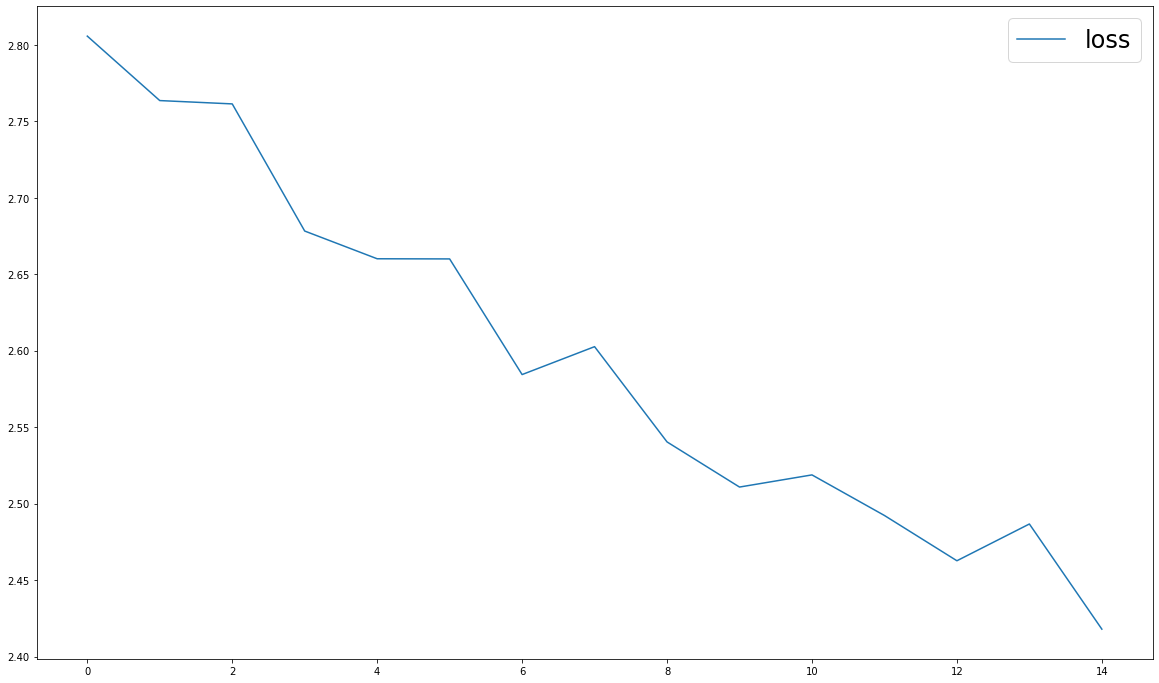

In [25]:
train_dataset = DataGenerator()

# Images
images_dir = '/dataset/dataset/train/'

# Ground truth
train_labels_filename = '/dataset/dataset/train_annotations.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'class_id', 'xmin', 'ymin', 'xmax', 'ymax'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        )

train_dataset_size = train_dataset.get_dataset_size()
#val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
#print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

batch_size = 16

data_augmentation = DataAugmentation(random_brightness=(-40, 40, 0.4),random_contrast=(0.3, 2.0, 0.4),random_saturation=(0.3, 2, 0.4),
                                    random_hue=(90, 0.4),overlap_criterion='area',bounds_box_filter=(0.3, 1.0))

predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3)
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)


model_checkpoint = ModelCheckpoint(filepath='ssd7_epoch-{epoch:02d}_loss-{loss:.4f}.h5',
                                   monitor='loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='ssd7_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             reduce_learning_rate]

initial_epoch   = 0
final_epoch     = 15
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              initial_epoch=initial_epoch)

plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.legend(loc='upper right', prop={'size': 24});

In [93]:
from locale import nl_langinfo
def _greedy_nms(predictions, iou_threshold=0.45):
  boxes_left = np.copy(predictions)
  maxima = []

  #print('boxes left')
  #print(boxes_left.shape)

  while boxes_left.shape[0] > 0:
    maximum_index = np.argmax(boxes_left[:,0])
    maximum_box = np.copy(boxes_left[maximum_index])
    #print('maximum_box')
    #print(maximum_box)
    maxima.append(maximum_box)
    boxes_left = np.delete(boxes_left, maximum_index, axis=0)
    if boxes_left.shape[0] == 0: break
    #print('iou params')
    #print(boxes_left[:,1:])
    #print(maximum_box[1:])
    similarities = iou(boxes_left[:,1:], maximum_box[1:], mode='element-wise',coords='corners') 
    #print('similarities')
    #print(similarities)
    boxes_left = boxes_left[similarities <= iou_threshold]

  return np.array(maxima)


def decode_detections(y_pred,confidence_thresh=0.01,iou_threshold=0.45,top_k=200,img_height=None,img_width=None):
  y_pred_decoded_raw = np.copy(y_pred[:,:,:-8])

  y_pred_decoded_raw[:,:,[-2,-1]] = np.exp(y_pred_decoded_raw[:,:,[-2,-1]] * y_pred[:,:,[-2,-1]])
  y_pred_decoded_raw[:,:,[-2,-1]] *= y_pred[:,:,[-6,-5]]
  y_pred_decoded_raw[:,:,[-4,-3]] *= y_pred[:,:,[-4,-3]] * y_pred[:,:,[-6,-5]] 
  y_pred_decoded_raw[:,:,[-4,-3]] += y_pred[:,:,[-8,-7]] 
  y_pred_decoded_raw = convert_coordinates(y_pred_decoded_raw, start_index=-4, conversion='centroids2corners')

  n_classes = y_pred_decoded_raw.shape[-1] - 4

  #print('n_classes')
  #print(n_classes)

  y_pred_decoded = []
  for batch_item in y_pred_decoded_raw:
    #print(batch_item.shape)
    pred = [] 
    for class_id in range(1, n_classes): 
      single_class = batch_item[:,[class_id, -4, -3, -2, -1]]
      #print('single_class')
      #print(single_class.shape)
      threshold_met = single_class[single_class[:,0] > confidence_thresh]
      #print('threshold') 
      #print(threshold_met.shape)
      #print(threshold_met.shape[0])
      if threshold_met.shape[0] > 0: 
        maxima = _greedy_nms(threshold_met, iou_threshold=iou_threshold) 
        #print(maxima)
        maxima_output = np.zeros((maxima.shape[0], maxima.shape[1] + 1))
        maxima_output[:,0] = class_id 
        maxima_output[:,1:] = maxima 
        pred.append(maxima_output) 
    if pred: 
      pred = np.concatenate(pred, axis=0)
      if top_k != 'all' and pred.shape[0] > top_k: 
        top_k_indices = np.argpartition(pred[:,1], kth=pred.shape[0]-top_k, axis=0)[pred.shape[0]-top_k:] 
        pred = pred[top_k_indices]
    else:
      pred = np.array(pred) 
    y_pred_decoded.append(pred) 

  return y_pred_decoded

Testiranje

Image: /dataset/dataset/test/00366_jpg.rf.875a1533de6ceb31a346a9b5075aae71.jpg

Ground truth boxes:

[[  5  71  44 140  86]]

(1, 7160, 18)
(7160, 10)


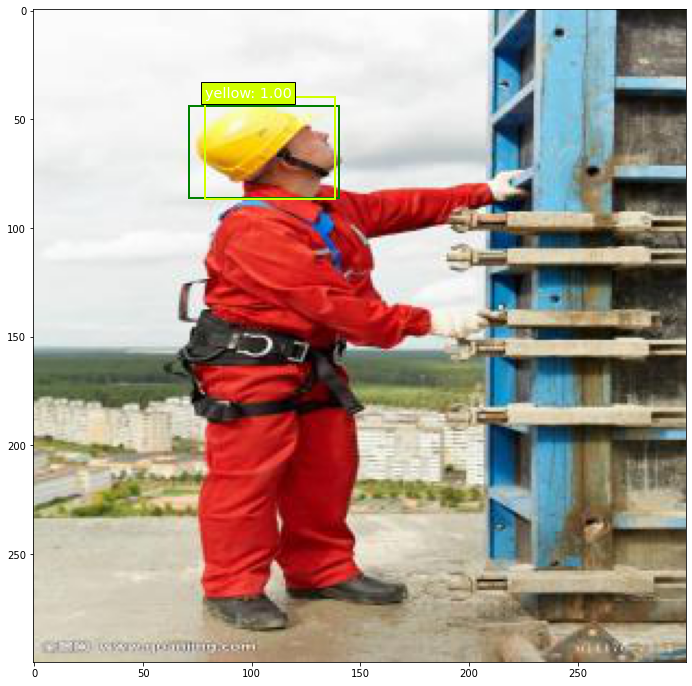

In [92]:
test_dataset = DataGenerator()

# Images
images_dir_test = '/dataset/dataset/test/'

# Ground truth
test_labels_filename = '/dataset/dataset/test_annotations.csv'

test_dataset.parse_csv(images_dir=images_dir_test,
                        labels_filename=test_labels_filename,
                        input_format=['image_name', 'class_id', 'xmin', 'ymin', 'xmax', 'ymax'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        )

predict_generator = test_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)

batch_images, batch_labels, batch_filenames = next(predict_generator)

if(False):
  model_path = '/content/ssd7_epoch-15_loss-2.4179.h5'
  ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
  K.clear_session()
  model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

y_pred = model.predict(batch_images)

print()
print(y_pred.shape)

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   img_height=img_height,
                                   img_width=img_width)

plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

colors=[[1.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.09375, 1.0], [1.0, 1.0, 1.0, 1.0], [0.0, 0.4562523625023627, 1.0, 1.0], [0.8187488187488188, 1.0, 0.0, 1.0]]
classes = ['background', 'none','red','white','blue','yellow'] # Just so we can print class names onto the image instead of IDs

# Iscrtavanje ground truth boxes u zelenom
for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  

# Iscrtavanje predikcija u odgovarajucoj boji
for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [23]:
from math import ceil
from tqdm import trange
import sys

def apply_inverse_transforms(y_pred_decoded, inverse_transforms):
  if isinstance(y_pred_decoded, list):

        y_pred_decoded_inv = []

        for i in range(len(y_pred_decoded)):
            y_pred_decoded_inv.append(np.copy(y_pred_decoded[i]))
            if y_pred_decoded_inv[i].size > 0: 
                for inverter in inverse_transforms[i]:
                    if not (inverter is None):
                        y_pred_decoded_inv[i] = inverter(y_pred_decoded_inv[i])

  elif isinstance(y_pred_decoded, np.ndarray):

      y_pred_decoded_inv = np.copy(y_pred_decoded)

      for i in range(len(y_pred_decoded)):
          if y_pred_decoded_inv[i].size > 0: # If there are any predictions for this batch item.
              for inverter in inverse_transforms[i]:
                  if not (inverter is None):
                      y_pred_decoded_inv[i] = inverter(y_pred_decoded_inv[i])

  return y_pred_decoded_inv

class Evaluator:
  def __init__(self,
                 model,
                 n_classes,
                 data_generator,
                 model_mode='inference',
                 pred_format={'class_id': 0, 'conf': 1, 'xmin': 2, 'ymin': 3, 'xmax': 4, 'ymax': 5},
                 gt_format={'class_id': 0, 'xmin': 1, 'ymin': 2, 'xmax': 3, 'ymax': 4}):
    
    self.model = model
    self.data_generator = data_generator
    self.n_classes = n_classes
    self.model_mode = model_mode
    self.pred_format = pred_format
    self.gt_format = gt_format

    # liste duzine broj klasa+1 koje sadrze podatke po klasama
    self.prediction_results = None
    self.num_gt_per_class = None
    self.true_positives = None
    self.false_positives = None
    self.cumulative_true_positives = None
    self.cumulative_false_positives = None
    self.cumulative_precisions = None # "Cumulative" means that the i-th element in each list represents the precision for the first i highest condidence predictions for that class.
    self.cumulative_recalls = None # "Cumulative" means that the i-th element in each list represents the recall for the first i highest condidence predictions for that class.
    self.average_precisions = None
    self.mean_average_precision = None

  def __call__(self,
                 img_height,
                 img_width,
                 batch_size,
                 data_generator_mode='resize',
                 round_confidences=False,
                 matching_iou_threshold=0.5,
                 border_pixels='include',
                 sorting_algorithm='quicksort',
                 average_precision_mode='sample',
                 num_recall_points=11,
                 return_precisions=False,
                 return_recalls=False,
                 return_average_precisions=False,
                 verbose=True,
                 decoding_confidence_thresh=0.01,
                 decoding_iou_threshold=0.45,
                 decoding_top_k=200,
                 decoding_pred_coords='centroids',
                 decoding_normalize_coords=True):
    
    self.predict_on_dataset(img_height=img_height,
                                img_width=img_width,
                                batch_size=batch_size,
                                data_generator_mode=data_generator_mode,
                                decoding_confidence_thresh=decoding_confidence_thresh,
                                decoding_iou_threshold=decoding_iou_threshold,
                                decoding_top_k=decoding_top_k,
                                decoding_pred_coords=decoding_pred_coords,
                                decoding_border_pixels=border_pixels,
                                round_confidences=round_confidences,
                                verbose=verbose,
                                ret=False)
    
    self.get_num_gt_per_class(verbose=False,
                                  ret=False)
    
    self.match_predictions(matching_iou_threshold=matching_iou_threshold,
                               border_pixels=border_pixels,
                               sorting_algorithm=sorting_algorithm,
                               verbose=verbose,
                               ret=False)
    self.compute_precision_recall(verbose=verbose, ret=False)

    self.compute_average_precisions(mode=average_precision_mode,
                                        num_recall_points=num_recall_points,
                                        verbose=verbose,
                                        ret=False)
    mean_average_precision = self.compute_mean_average_precision(ret=True)

    if return_precisions or return_recalls or return_average_precisions:
        ret = [mean_average_precision]
        if return_average_precisions:
            ret.append(self.average_precisions)
        if return_precisions:
            ret.append(self.cumulative_precisions)
        if return_recalls:
            ret.append(self.cumulative_recalls)
        return ret
    else:
        return mean_average_precision

    
  def predict_on_dataset(self,
                           img_height,
                           img_width,
                           batch_size,
                           data_generator_mode='resize',
                           decoding_confidence_thresh=0.01,
                           decoding_iou_threshold=0.45,
                           decoding_top_k=200,
                           decoding_pred_coords='centroids',
                           decoding_border_pixels='include',
                           round_confidences=False,
                           verbose=True,
                           ret=False):
    
    class_id_pred = self.pred_format['class_id']
    conf_pred     = self.pred_format['conf']
    xmin_pred     = self.pred_format['xmin']
    ymin_pred     = self.pred_format['ymin']
    xmax_pred     = self.pred_format['xmax']
    ymax_pred     = self.pred_format['ymax']

    convert_to_3_channels = ConvertTo3Channels()
    #resize = Resize(height=img_height,width=img_width, labels_format=self.gt_format)

    transformations = [convert_to_3_channels]

    generator = self.data_generator.generate(batch_size=batch_size,
                                                 shuffle=False,
                                                 transformations=transformations,
                                                 label_encoder=None,
                                                 returns={'processed_images',
                                                          'image_ids',
                                                          'evaluation-neutral',
                                                          'inverse_transform',
                                                          'original_labels'},

                                                 keep_images_without_gt=True,
                                                 degenerate_box_handling='remove')
    
    if self.data_generator.image_ids is None:
      self.data_generator.image_ids = list(range(self.data_generator.get_dataset_size()))

    #posebna lista za rezultate za svaku klasu
    results = [list() for _ in range(self.n_classes + 1)]

    #dict koji mapira id slike na ground truth anotacije
    image_ids_to_labels = {}

    #racunamo broj batchova
    n_images = self.data_generator.get_dataset_size()
    n_batches = int(ceil(n_images / batch_size))
    if verbose:
        print("Number of images in the evaluation dataset: {}".format(n_images))
        print()
        tr = trange(n_batches, file=sys.stdout)
        tr.set_description('Producing predictions batch-wise')
    else:
        tr = range(n_batches)

    #prolazak kroz sve batcheve
    for j in tr:
            # napravi batch
            batch_X, batch_image_ids, batch_inverse_transforms, batch_orig_labels = next(generator)
            # racunaj predikciju
            y_pred = self.model.predict(batch_X)
            if self.model_mode == 'training':
                # dekodiranje
                y_pred = decode_detections(y_pred,
                                           confidence_thresh=decoding_confidence_thresh,
                                           iou_threshold=decoding_iou_threshold,
                                           top_k=decoding_top_k,
                                           img_height=img_height,
                                           img_width=img_width)
            else:
                # isfiltriraj elemnte kod kojih su sve nule
                y_pred_filtered = []
                for i in range(len(y_pred)):
                    y_pred_filtered.append(y_pred[i][y_pred[i,:,0] != 0])
                y_pred = y_pred_filtered
            # konverzija koordinata predikcija za originalne slike
            y_pred = apply_inverse_transforms(y_pred, batch_inverse_transforms)

            # prolazak kroz sve iteme batcha.
            for k, batch_item in enumerate(y_pred):

                image_id = batch_image_ids[k]

                for box in batch_item:
                    class_id = int(box[class_id_pred])
                    
                    confidence = box[conf_pred]
                    xmin = round(box[xmin_pred], 1)
                    ymin = round(box[ymin_pred], 1)
                    xmax = round(box[xmax_pred], 1)
                    ymax = round(box[ymax_pred], 1)
                    prediction = (image_id, confidence, xmin, ymin, xmax, ymax)
                    # Dodaje se predikcija u listu za svoju klasu
                    results[class_id].append(prediction)

    self.prediction_results = results

    if ret:
        return results

  def get_num_gt_per_class(self,
                             verbose=True,
                             ret=False):
    
    num_gt_per_class = np.zeros(shape=(self.n_classes+1), dtype=np.int)

    class_id_index = self.gt_format['class_id']

    ground_truth = self.data_generator.labels

    if verbose:
        print('Computing the number of positive ground truth boxes per class.')
        tr = trange(len(ground_truth), file=sys.stdout)
    else:
        tr = range(len(ground_truth))

    # Iteriranje kroz ground truths za sve slike dataseta
    for i in tr:
        boxes = np.asarray(ground_truth[i])
        # Iteriranje kroz ground truth boxes trenutne slike
        for j in range(boxes.shape[0]):
            class_id = boxes[j, class_id_index]
            num_gt_per_class[class_id] += 1

    self.num_gt_per_class = num_gt_per_class

    if ret:
        return num_gt_per_class

  def match_predictions(self,
                          matching_iou_threshold=0.5,
                          border_pixels='include',
                          sorting_algorithm='quicksort',
                          verbose=True,
                          ret=False):

    class_id_gt = self.gt_format['class_id']
    xmin_gt = self.gt_format['xmin']
    ymin_gt = self.gt_format['ymin']
    xmax_gt = self.gt_format['xmax']
    ymax_gt = self.gt_format['ymax']

    ground_truth = {}

    for i in range(len(self.data_generator.image_ids)):
        image_id = str(self.data_generator.image_ids[i])
        labels = self.data_generator.labels[i]
        ground_truth[image_id] = np.asarray(labels)

    true_positives = [[]] # The false positives for each class, sorted by descending confidence.
    false_positives = [[]] # The true positives for each class, sorted by descending confidence.
    cumulative_true_positives = [[]]
    cumulative_false_positives = [[]]

    for class_id in range(1, self.n_classes + 1):

        predictions = self.prediction_results[class_id]

        predictions = self.prediction_results[class_id]

        true_pos = np.zeros(len(predictions), dtype=np.int) # 1 za svaki TP, u suprotnom 0
        false_pos = np.zeros(len(predictions), dtype=np.int) # 1 za svaki FP, u suprotnom 0

        #ako nema predikcija za ovu klasu
        if len(predictions) == 0:
                print("No predictions for class {}/{}".format(class_id, self.n_classes))
                true_positives.append(true_pos)
                false_positives.append(false_pos)
                continue

        num_chars_per_image_id = len(str(predictions[0][0])) + 6

        preds_data_type = np.dtype([('image_id', 'U{}'.format(num_chars_per_image_id)),
                                      ('confidence', 'f4'),
                                      ('xmin', 'f4'),
                                      ('ymin', 'f4'),
                                      ('xmax', 'f4'),
                                      ('ymax', 'f4')])
        # pravimo struktuiran niz
        predictions = np.array(predictions, dtype=preds_data_type)

        # sortiranje po opadajucoj conf
        descending_indices = np.argsort(-predictions['confidence'], kind=sorting_algorithm)
        predictions_sorted = predictions[descending_indices]

        if verbose:
            tr = trange(len(predictions), file=sys.stdout)
            tr.set_description("Matching predictions to ground truth, class {}/{}.".format(class_id, self.n_classes))
        else:
            tr = range(len(predictions.shape))

        # Keep track of which ground truth boxes were already matched to a detection.
        gt_matched = {}

        #iteriramo kroz predikcije
        for i in tr:

                prediction = predictions_sorted[i]
                image_id = prediction['image_id']
                pred_box = np.asarray(list(prediction[['xmin', 'ymin', 'xmax', 'ymax']])) # konvertujemo strukturiran u obican niz


                #uzimamo ground truth boxes koje se poklapaju id slike i id klase predikcije
                gt = ground_truth[image_id]
                gt = np.asarray(gt)
                class_mask = gt[:,class_id_gt] == class_id
                gt = gt[class_mask]

                if gt.size == 0:
                    # Ako slika nema nijedan objekat ove klase, onda je FP
                    false_pos[i] = 1
                    continue

                # racunamo iou ove predikcije sa svim ground boxovima ove klase
                overlaps = iou(boxes1=gt[:,[xmin_gt, ymin_gt, xmax_gt, ymax_gt]],
                               boxes2=pred_box,
                               coords='corners',
                               mode='element-wise')

                
                #za svaku detekciju, macujemo ground truth box sa najvecim preklapanjem
                gt_match_index = np.argmax(overlaps)
                gt_match_overlap = overlaps[gt_match_index]

                if gt_match_overlap < matching_iou_threshold:
                    # FP, IoU threshold narusen: - postaju FP
                    false_pos[i] = 1
                else:
                    if not (image_id in gt_matched):
                            # True positive: ako nije vec mecovano sa drugom predikcijom onda je TP
                            true_pos[i] = 1
                            gt_matched[image_id] = np.zeros(shape=(gt.shape[0]), dtype=np.bool)
                            gt_matched[image_id][gt_match_index] = True
                    elif not gt_matched[image_id][gt_match_index]:
                        # True positive: ako nije vec mecovano sa drugom predikcijom onda je TP
                        true_pos[i] = 1
                        gt_matched[image_id][gt_match_index] = True
                    else:
                        # FP, dupla detekcija
                        false_pos[i] = 1

        true_positives.append(true_pos)
        false_positives.append(false_pos)

        cumulative_true_pos = np.cumsum(true_pos) # Cumulative sums of the true positives
        cumulative_false_pos = np.cumsum(false_pos) # Cumulative sums of the false positives

        cumulative_true_positives.append(cumulative_true_pos)
        cumulative_false_positives.append(cumulative_false_pos)

    self.true_positives = true_positives
    self.false_positives = false_positives
    self.cumulative_true_positives = cumulative_true_positives
    self.cumulative_false_positives = cumulative_false_positives

    if ret:
        return true_positives, false_positives, cumulative_true_positives, cumulative_false_positives

    
  def compute_precision_recall(self, verbose=True, ret=False):

        cumulative_precisions = [[]]
        cumulative_recalls = [[]]

        # Iterate over all classes.
        for class_id in range(1, self.n_classes + 1):

            if verbose:
                print("Computing precisions and recalls, class {}/{}".format(class_id, self.n_classes))

            tp = self.cumulative_true_positives[class_id]
            fp = self.cumulative_false_positives[class_id]


            cumulative_precision = np.where(tp + fp > 0, tp / (tp + fp), 0) # 1D niz oblika `(broj predikcija,)`
            cumulative_recall = tp / self.num_gt_per_class[class_id] # 1D niz oblika `(broj predikcija,)`

            cumulative_precisions.append(cumulative_precision)
            cumulative_recalls.append(cumulative_recall)

        self.cumulative_precisions = cumulative_precisions
        self.cumulative_recalls = cumulative_recalls

        if ret:
            return cumulative_precisions, cumulative_recalls

  def compute_average_precisions(self, mode='sample', num_recall_points=11, verbose=True, ret=False):
     average_precisions = [0.0]

     for class_id in range(1, self.n_classes + 1):

          if verbose:
              print("Computing average precision, class {}/{}".format(class_id, self.n_classes))

          cumulative_precision = self.cumulative_precisions[class_id]
          cumulative_recall = self.cumulative_recalls[class_id]
          average_precision = 0.0

          for t in np.linspace(start=0, stop=1, num=num_recall_points, endpoint=True):

              cum_prec_recall_greater_t = cumulative_precision[cumulative_recall >= t]

              if cum_prec_recall_greater_t.size == 0:
                  precision = 0.0
              else:
                  precision = np.amax(cum_prec_recall_greater_t)

              average_precision += precision

          average_precision /= num_recall_points
          average_precisions.append(average_precision)

     self.average_precisions = average_precisions

     if ret:
        return average_precisions

  
  def compute_mean_average_precision(self, ret=True):
        mean_average_precision = np.average(self.average_precisions[1:])
        self.mean_average_precision = mean_average_precision

        if ret:
            return mean_average_precision

In [98]:
img_height = 300
img_width = 300
n_classes = 5
model_mode = 'training'


model_path = '/content/ssd7_epoch-15_loss-2.8809.h5'
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
K.clear_session()
model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                              'compute_loss': ssd_loss.compute_loss})

evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=test_dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=8,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

Number of images in the evaluation dataset: 632

Matching predictions to ground truth, class 5/5.: 100%|██████████| 13728/13728 [00:00<00:00, 13731.98it/s]
Computing precisions and recalls, class 1/5
Computing precisions and recalls, class 2/5
Computing precisions and recalls, class 3/5
Computing precisions and recalls, class 4/5
Computing precisions and recalls, class 5/5
Computing average precision, class 1/5
Computing average precision, class 2/5
Computing average precision, class 3/5
Computing average precision, class 4/5
Computing average precision, class 5/5
none          AP    0.357
red           AP    0.431
white         AP    0.495
blue          AP    0.542
yellow        AP    0.492

              mAP   0.464
